In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
train_set = keras.preprocessing.image_dataset_from_directory(
   "C:/Users/user/Downloads/archive/Training",
    labels='inferred',  # Automatically infer labels from subdirectory names
    label_mode='int',
    interpolation='nearest',
    batch_size=32,
    image_size=(256,256)
)

test_set = keras.preprocessing.image_dataset_from_directory(
    "C:/Users/user/Downloads/archive/Testing",
    labels='inferred',  # Automatically infer labels from subdirectory names
    label_mode='int',
    interpolation='nearest',
    batch_size=32,
    image_size=(256,256)
)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [3]:
class_names = train_set.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [4]:
# prompt: get the number of samples in test and train set

num_train_samples = 0
for batch in train_set:
    num_train_samples += batch[0].shape[0]

num_test_samples = 0
for batch in test_set:
    num_test_samples += batch[0].shape[0]

print("Number of training samples:", num_train_samples)
print("Number of testing samples:", num_test_samples)

Number of training samples: 5712
Number of testing samples: 1311


In [5]:
# prompt: view the info of the train_set and test_set

print(train_set)
test_set

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
# plt.figure(figsize=(12,12))
# for img, label in train_set.take(1):
#     for i in range(25):
#         plt.subplot(5,5,i+1)
#         plt.imshow(img[i])
#         plt.title(class_names[label[i]])
#         plt.axis('off')

In [7]:
# prompt: get the number of images based on the class names

import os

image_counts = {}
for class_name in class_names:
  class_dir = os.path.join("C:/Users/user/Downloads/archive/Training", class_name)
  image_count = len(os.listdir(class_dir))
  image_counts[class_name] = image_count

for class_name, count in image_counts.items():
  print(f"Class: {class_name}, Number of images: {count}")

Class: glioma, Number of images: 1321
Class: meningioma, Number of images: 1339
Class: notumor, Number of images: 1595
Class: pituitary, Number of images: 1457


In [8]:
image_counts = {}
for class_name in class_names:
  class_dir = os.path.join("C:/Users/user/Downloads/archive/Testing", class_name)
  image_count = len(os.listdir(class_dir))
  image_counts[class_name] = image_count

for class_name, count in image_counts.items():
  print(f"Class: {class_name}, Number of images: {count}")

Class: glioma, Number of images: 300
Class: meningioma, Number of images: 306
Class: notumor, Number of images: 405
Class: pituitary, Number of images: 300


In [9]:
# prompt: combine the train and test test into a single varible to store the 7000+ image data with its class

import tensorflow as tf

# Combine the datasets
combined_dataset = train_set.concatenate(test_set)

# You can now iterate through the combined dataset
# Example: Print the shapes of the first batch
for image_batch, label_batch in combined_dataset.take(1):
  print("Image batch shape:", image_batch.shape)
  print("Label batch shape:", label_batch.shape)

#Further processing or storage of combined_dataset
#Example: Convert to NumPy arrays for easier manipulation if needed
images = []
labels = []

for image_batch, label_batch in combined_dataset:
    images.extend(image_batch.numpy())
    labels.extend(label_batch.numpy())

#Now images and labels are NumPy arrays containing all the data.
images = np.array(images)
labels = np.array(labels)
print("Total number of Image and labels:",images.shape, labels.shape)

Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)
Total number of Image and labels: (7023, 256, 256, 3) (7023,)


In [10]:
print("Labels and their corresponding numerical values:")
for i, class_name in enumerate(class_names):
  print(f"{i}: {class_name}")

Labels and their corresponding numerical values:
0: glioma
1: meningioma
2: notumor
3: pituitary


In [11]:
# prompt: store the images and labels variable into a single variable called data

data = (images, labels)

In [12]:
images, labels = data

# Create a DataFrame
df = pd.DataFrame({'image': list(images), 'label': list(labels)})

# Print the DataFrame (or perform other operations)
print(df.info()) # Print the first few rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7023 entries, 0 to 7022
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   7023 non-null   object
 1   label   7023 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 82.4+ KB
None


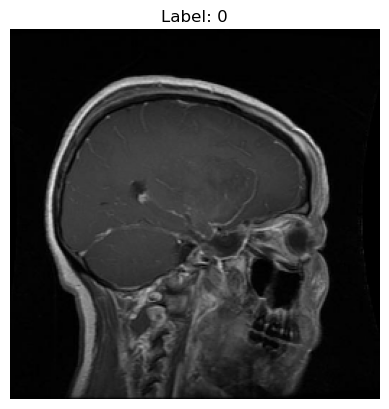

In [13]:
#  view the image that store in the data variable
plt.imshow(data[0][0])  # Access the first image (index 0)
plt.title(f"Label: {data[1][0]}") #Display the label of the first image
plt.axis('off')
plt.show()

In [14]:
input_shape = images.shape[1:]  # Get the shape of your images
num_classes = len(np.unique(labels))  # Get the number of unique classes

print(input_shape)
print(num_classes)

(256, 256, 3)
4


## Simple CNN

In [15]:
# prompt:  use simple cnn to train the model and evaluate the result

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics
import matplotlib.pyplot as plt

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax') # Output layer with number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])

# Train the model
history = model.fit(train_set, epochs=10, validation_data=test_set) # Adjust epochs as needed


# Evaluate the model
loss, accuracy = model.evaluate(test_set)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Plot training history (optional)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

Epoch 1/10
 20/179 [==>...........................] - ETA: 3:41 - loss: 186.4034 - accuracy: 0.3734

In [ ]:
model.summary()

## Simple CNN + GoogleNet

In [ ]:
# prompt: use googlenet to train the model and evaluate the result

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models, metrics
import matplotlib.pyplot as plt

# ... (Your existing code for data loading and preprocessing) ...

# Load pre-trained InceptionV3 model (excluding the top classification layer)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling2D
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(len(class_names), activation='softmax')(x)

# Create the final model
model3 = models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model3.summary()

In [ ]:
# Train the model
history = model3.fit(train_set, epochs=10, validation_data=test_set)

In [ ]:
# Evaluate the model
loss, accuracy = model3.evaluate(test_set)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Plot training history (optional)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

## Multiscale CNN

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics
import numpy as np
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define the multi-scale CNN model
def create_multiscale_cnn(input_shape, num_classes):
    input_tensor = keras.Input(shape=input_shape)

    # Define multiple convolutional branches with different kernel sizes
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
    conv1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(input_tensor)
    conv2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(32, (7, 7), activation='relu', padding='same')(input_tensor)
    conv3 = layers.MaxPooling2D((2, 2))(conv3)

    # Concatenate the outputs ofc  f the different branches
    merged = layers.concatenate([conv1, conv2, conv3])

    # Add further convolutional and pooling layers
    merged = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merged)
    merged = layers.MaxPooling2D((2, 2))(merged)

    merged = layers.Flatten()(merged)
    merged = layers.Dense(128, activation='relu')(merged)
    output_tensor = layers.Dense(num_classes, activation='softmax')(merged)

    model4 = models.Model(inputs=input_tensor, outputs=output_tensor)
    return model4

# Assuming 'images' and 'labels' are your NumPy arrays
input_shape = images.shape[1:]  # Get the shape of your images
num_classes = len(np.unique(labels))  # Get the number of unique classes

# Create the model
model4 = create_multiscale_cnn(input_shape, num_classes)

# Compile the model
model4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
              metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=3,         # Stop after 3 epochs with no improvement
                               restore_best_weights=True,  # Restore the best weights when stopping
                               verbose=1)

# Set the break duration (in seconds)
pause_duration = 30  # 10 seconds break before each epoch

# Custom training loop with a pause before each epoch
epochs = 10  # Number of epochs

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Train for 1 epoch with the EarlyStopping callback
    history = model4.fit(images, labels, batch_size=16, validation_split=0.2, epochs=1, callbacks=[early_stopping])

    # Pause before the next epoch
    print(f"Pausing for {pause_duration} seconds before next epoch...")
    time.sleep(pause_duration)  # Pause for the specified duration

# Evaluate the model
loss, accuracy = model4.evaluate(test_set)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10
352/352 [==============================] - 525s 1s/step - loss: 36.5224 - accuracy: 0.8047 - val_loss: 0.4799 - val_accuracy: 0.8477
Pausing for 30 seconds before next epoch...
Epoch 2/10
352/352 [==============================] - 508s 1s/step - loss: 0.3555 - accuracy: 0.8959 - val_loss: 0.4893 - val_accuracy: 0.8377
Pausing for 30 seconds before next epoch...
Epoch 3/10
352/352 [==============================] - 508s 1s/step - loss: 0.2499 - accuracy: 0.9194 - val_loss: 0.3216 - val_accuracy: 0.8961
Pausing for 30 seconds before next epoch...
Epoch 4/10
352/352 [==============================] - 509s 1s/step - loss: 0.1539 - accuracy: 0.9530 - val_loss: 0.3410 - val_accuracy: 0.8940
Pausing for 30 seconds before next epoch...
Epoch 5/10
352/352 [==============================] - 593s 2s/step - loss: 0.0910 - accuracy: 0.9706 - val_loss: 0.4012 - val_accuracy: 0.9132
Pausing for 30 seconds before next epoch...
Epoch 6/10
352/352 [==============================] - 550s 2s/st

## MS-CNN + GoogLeNet

In [29]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define input shapes for multi-scale
input_shapes = [(256, 256, 3), (128, 128, 3), (64, 64, 3)]  # Example multi-scale input

# Create input layers for each scale
inputs = [Input(shape=shape) for shape in input_shapes]

# Create InceptionV3 instances for each input scale (without top classification layer)
inception_models = [InceptionV3(weights='imagenet', include_top=False, input_tensor=inp) for inp in inputs]

# Process the inceptionV3 output and add dense layers
x_list = []
for model in inception_models:
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x_list.append(x)

# Merge the feature maps from different scales
merged = concatenate(x_list)

# Final classification layer
predictions = Dense(len(class_names), activation='softmax')(merged)

# Create the multi-scale model
model5 = Model(inputs=inputs, outputs=predictions)

# Compile the model
model5.compile(optimizer=Adam(learning_rate=0.0001), 
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=3,         # Stop after 3 epochs with no improvement
                               restore_best_weights=True,  # Restore the best weights when stopping
                               verbose=1)

# Set the break duration (in seconds)
pause_duration = 60  # 10 seconds break before each epoch

# Reshape image data for multi-scale input
resized_images_256 = tf.image.resize(images, (256, 256))
resized_images_128 = tf.image.resize(images, (128, 128))
resized_images_64 = tf.image.resize(images, (64, 64))

# Custom training loop with a pause before each epoch
epochs = 10  # Number of epochs

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Train for 1 epoch with the EarlyStopping callback
    model5.fit([resized_images_256, resized_images_128, resized_images_64], labels, 
                          batch_size=16, validation_split=0.2, epochs=1, callbacks=[early_stopping])

    # Pause before the next epoch
    print(f"Pausing for {pause_duration} seconds before next epoch...")
    time.sleep(pause_duration)  # Pause for the specified duration

print("Training complete!")


ValueError: The name "mixed0" is used 3 times in the model. All operation names should be unique.